# L3: Token vs. Sentence Embeddings

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>


In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from transformers import BertModel, BertTokenizer
from datasets import load_dataset

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> file:</b> To access <code>requirements.txt</code> for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Setup

In [3]:
model_name = "./models/bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    attention_mask = encoded_input['attention_mask']   # to indicate which tokens are valid and which are padding
    
    # Get the model output (without the specific classification head)
    with torch.no_grad():
        output = model(**encoded_input)

    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    # mean pooling operation, considering the BERT input_mask and padding
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    return sentence_embedding.flatten().tolist()

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

In [5]:
# Helper function to plot similarity matrix
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

## Token Embeddings

In [6]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

<Axes: title={'center': 'Semantic Textual Similarity'}>

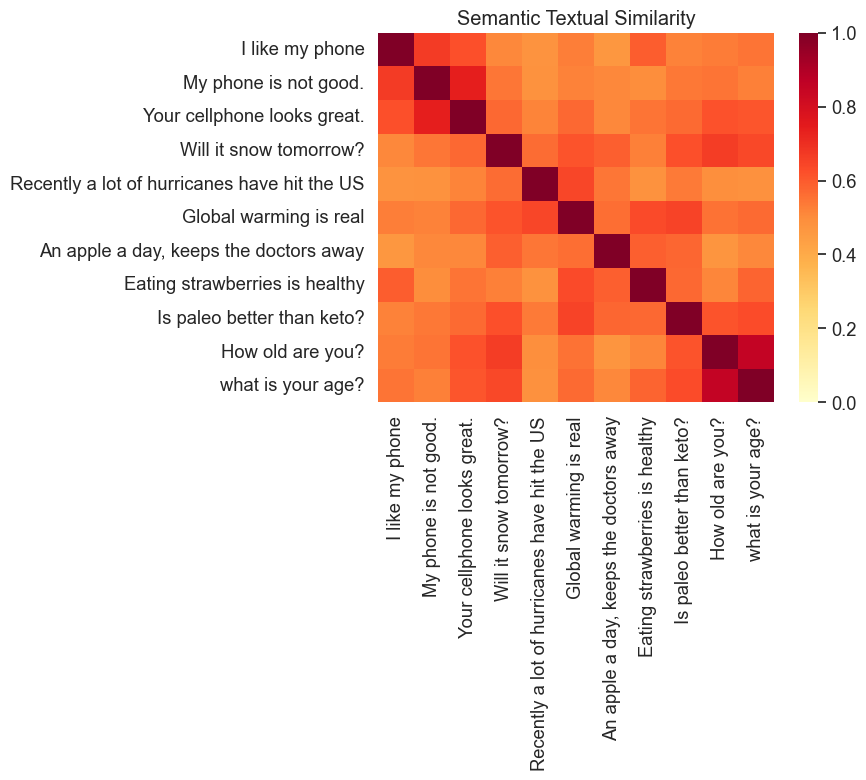

In [7]:
embeddings = []
for t in messages:
    emb = get_sentence_embedding(t)
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

## => Mean pooling doesn't work

In [8]:
sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({'sent1': sts_dataset['test']['sentence1'], 
                    'sent2': sts_dataset['test']['sentence2'],
                    'score': [x/5 for x in sts_dataset['test']['score']]})
sts.head(10)

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

,sent1,sent2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


<b>About the scores</b>: These scores are based on human evaluations and in the range 0 to 5 (see https://aclanthology.org/S17-2001.pdf table 1 for how they work). For example "A woman is cutting onions" vs "A woman is cutting tofu" can be considered by a human as in between 2-3 or so. The goal of STS is more to show another example where instead of just our intuition there is some kind of human labeled dataset, albeit it's not exactly a similarity in the sense of cosine but according to the rules of table 1 in the paper above.

In [9]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

n_examples = 50

sts = sts.head(n_examples)
sts['avg_bert_score'] = np.vectorize(sim_two_sentences) \
                                    (sts['sent1'], sts['sent2'])

In [10]:
sts.head(10)

,sent1,sent2,score,avg_bert_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588


In [11]:
pc = scipy.stats.pearsonr(sts['score'], sts['avg_bert_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.32100172202695454
p-value = 0.02303013509739929


## A better approach: SBERT and Dual Encoders

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<Axes: title={'center': 'Semantic Textual Similarity'}>

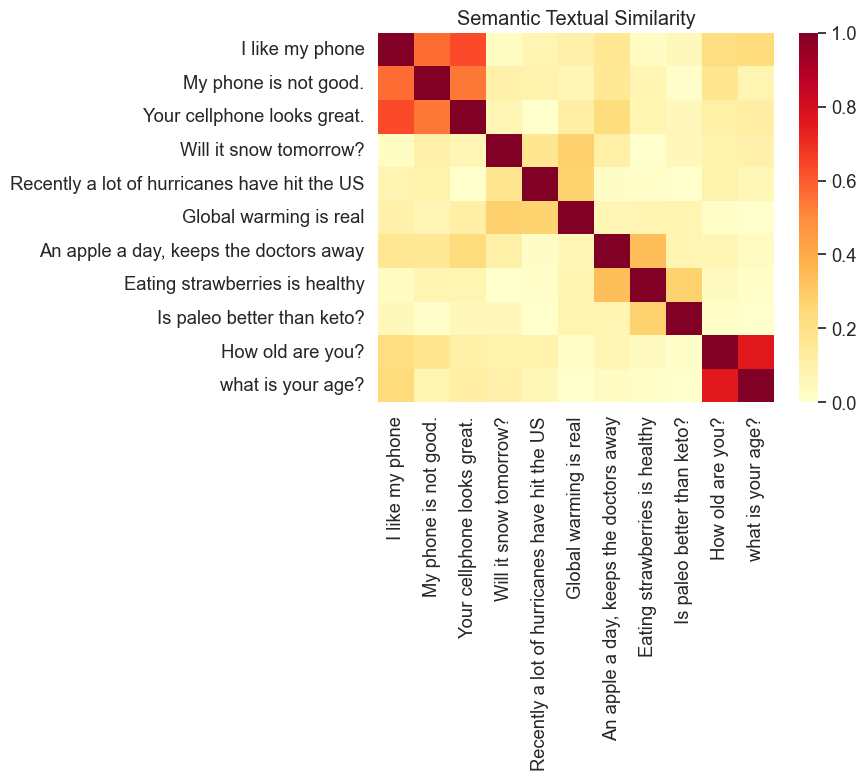

In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = []
for t in messages:
    emb = list(model.encode(t))
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

In [13]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sent1'], sts['sent2'])
sts.head(10)

,sent1,sent2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


In [14]:
pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.9303740673726042
p-value = 1.4823857251916192e-22


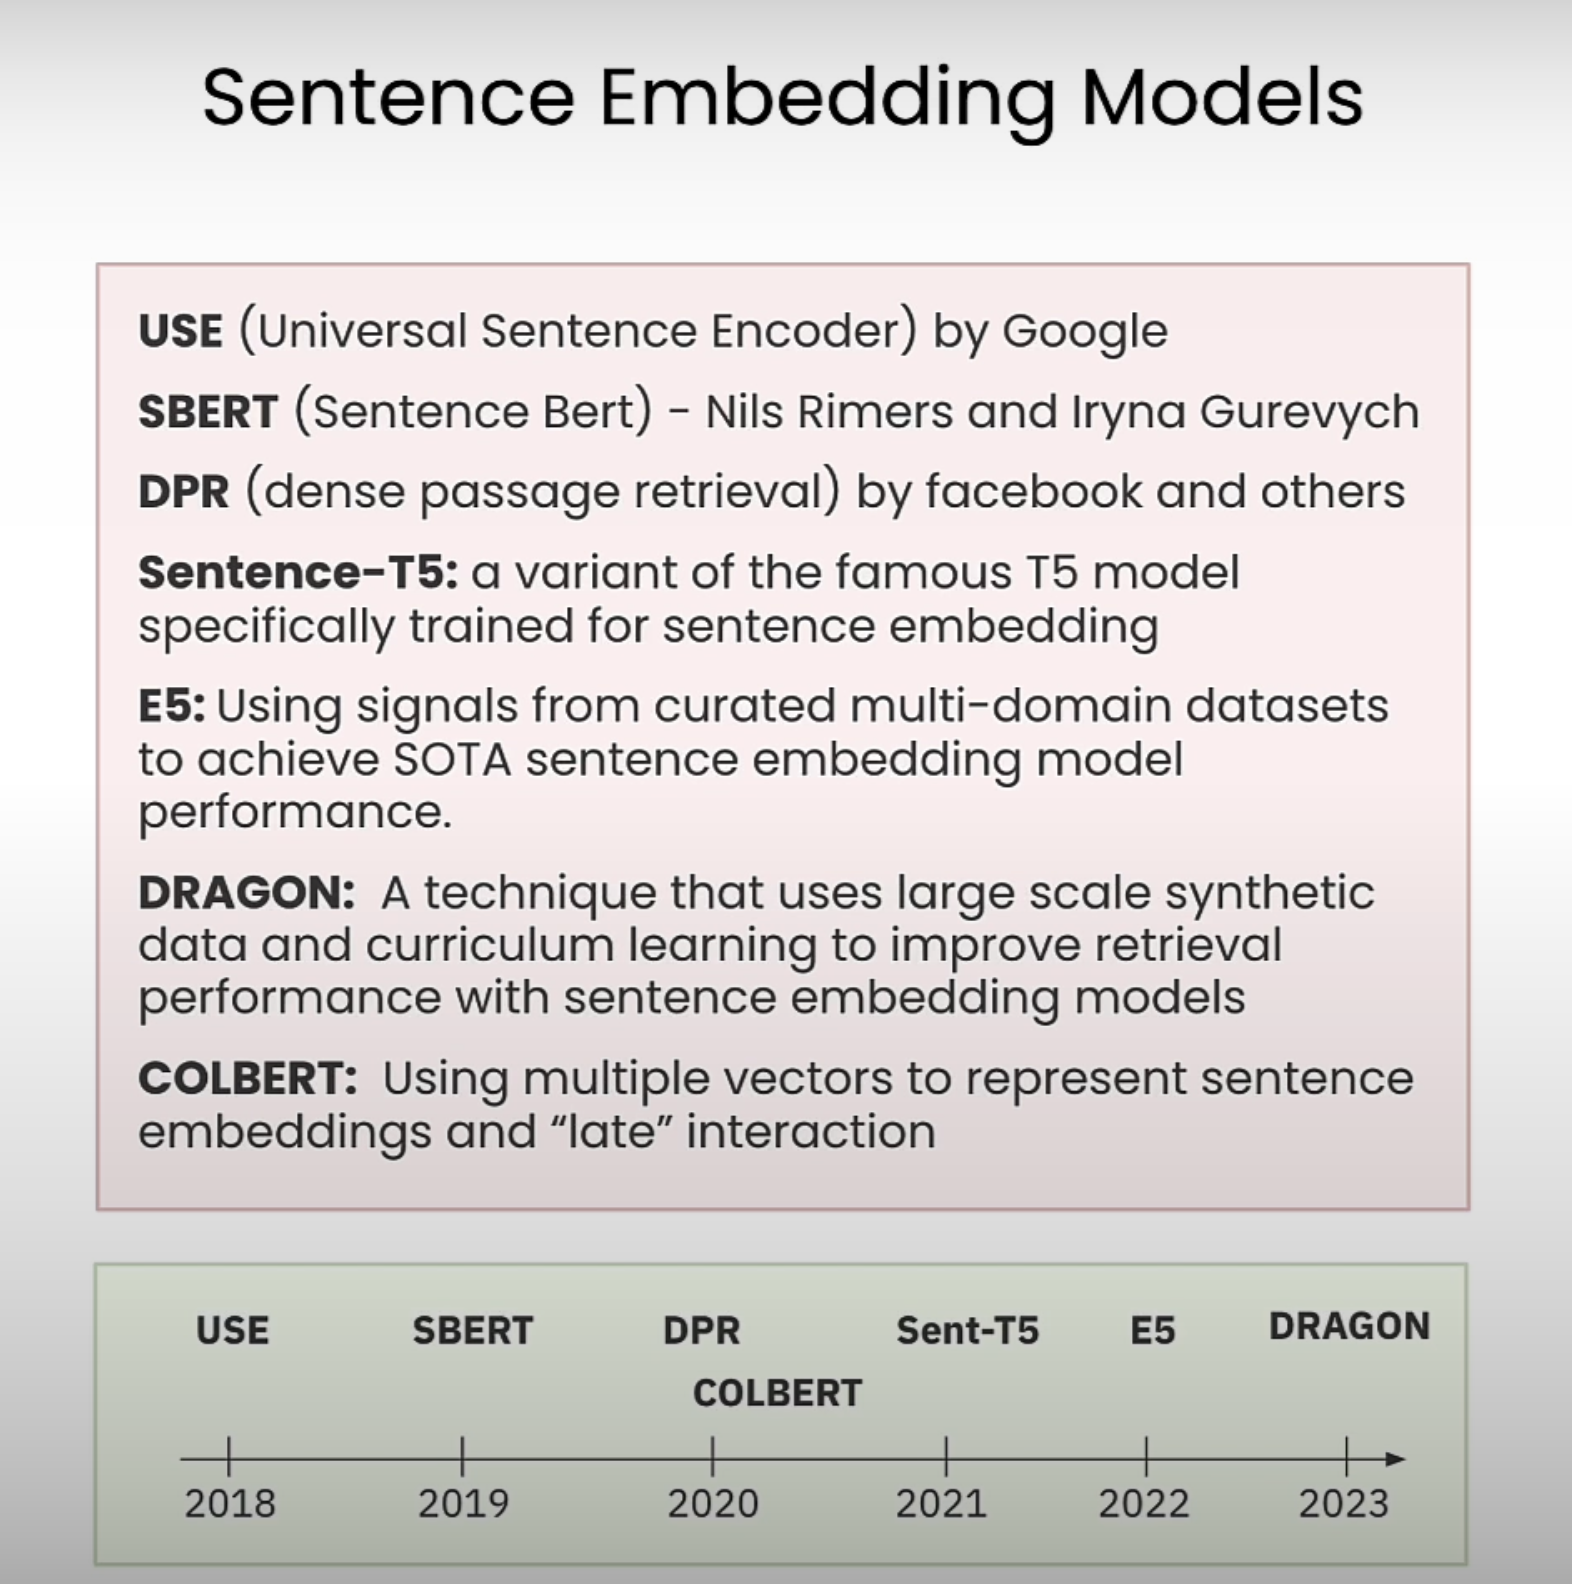

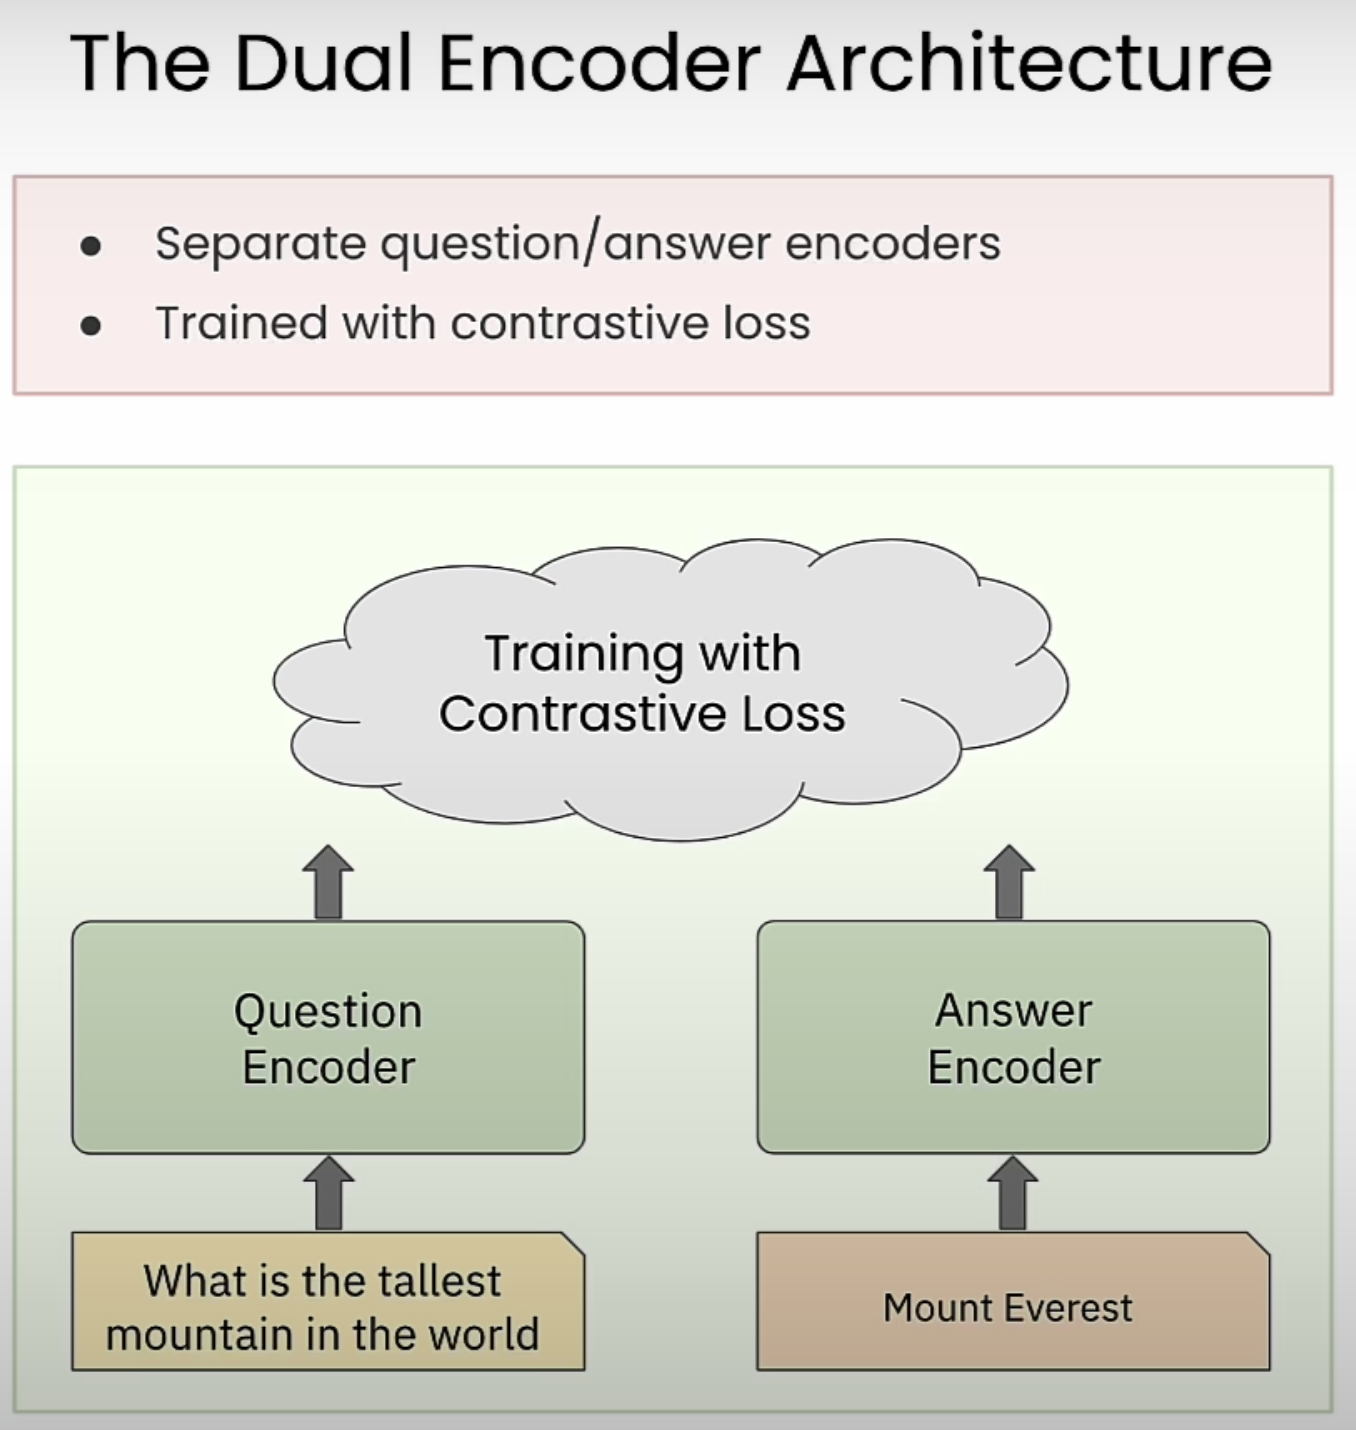
The goal of contrastive loss is to learn a feature space where similar data points (e.g., images, texts) are closer together and dissimilar ones are further apart.